### Make an Agent that can talk(chatbot) and also perform operation(actions) according to the human input

In [57]:
from langchain.tools import tool
from langgraph.graph import StateGraph, START, END
from langchain_core.messages import HumanMessage, BaseMessage, SystemMessage, ToolMessage, AIMessage
from langgraph.graph.message import add_messages
from langgraph.checkpoint.memory import MemorySaver
from langchain_community.tools import DuckDuckGoSearchRun
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from typing import Annotated, TypedDict, Literal
from dotenv import load_dotenv
from langchain_core.output_parsers import PydanticOutputParser
from langchain_core.prompts import PromptTemplate
from langchain_community.utilities import ArxivAPIWrapper, WikipediaAPIWrapper
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_tavily import TavilySearch
import os

In [58]:
load_dotenv()

True

In [19]:
llm = ChatGroq(
    model=os.getenv("model"),
    api_key=os.getenv("api_key")
)

In [20]:
# state
import operator
class Messagestate(TypedDict):
    messages : Annotated[list[BaseMessage], add_messages]
    plan : str

class Plan(BaseModel):
    plan : str = Field(description="the plan should in string format in point wide form")

PlanFormat = PydanticOutputParser(pydantic_object=Plan)

In [73]:
arxiv_wallpaper = ArxivAPIWrapper(top_k_results= 1, doc_content_chars_max= 400)
arxiv_tool = ArxivQueryRun(api_wrapper=arxiv_wallpaper)

wikipedia_wallpaper = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max= 150 )
wikipedia_tool = WikipediaQueryRun(api_wrapper=wikipedia_wallpaper)

tavily_tool = TavilySearch(max_results=1, topic='general', include_answer=True)

tavily_tool.invoke({'query' : "What are the latest breakthroughs in AI for 2026?"})

{'query': 'What are the latest breakthroughs in AI for 2026?',
 'follow_up_questions': None,
 'answer': 'In 2026, a new AI-powered version of Siri from Apple was released, revolutionizing voice assistant technology. This breakthrough marks a significant advancement in AI capabilities.',
 'images': [],
 'results': [{'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates',
   'title': 'Latest AI News and AI Breakthroughs that Matter Most: 2026 & 2025',
   'content': 'Summary: Apple has officially announced that a completely reimagined, AI-powered version of Siri is set to debut in 2026. This fundamental transformation will',
   'score': 0.9996259,
   'raw_content': None}],
 'response_time': 1.3,
 'request_id': '20c00f45-049b-4d4d-909d-1afcbe28fd72'}

In [38]:
print(wikipedia_tool.invoke("Criastiano Ronaldo"))

No good Wikipedia Search Result was found


In [67]:
from langchain.tools import tool


# Define tools
@tool
def multiply(a: int, b: int) -> int:
    """used to Multiply two given number `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a * b


@tool
def add(a: int, b: int) -> int:
    """used to Adds two given number`a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a + b

@tool
def subtract(a: int, b: int) -> int:
    """used to Subtract two given number`a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a - b

@tool
def divide(a: int, b: int) -> float:
    """used to Divide two given number `a` and `b`.

    Args:
        a: First int
        b: Second int
    """
    return a / b


# Augment the LLM with tools
tools = [add, subtract, multiply, divide, arxiv_tool, wikipedia_tool, tavily_tool]
tools_by_name = {tool.name: tool for tool in tools}
llm_with_tools = llm.bind_tools(tools)
print(tools_by_name)

{'add': StructuredTool(name='add', description='used to Adds two given number`a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.add'>, func=<function add at 0x00000239EB8580E0>), 'subtract': StructuredTool(name='subtract', description='used to Subtract two given number`a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.subtract'>, func=<function subtract at 0x00000239EB8587C0>), 'multiply': StructuredTool(name='multiply', description='used to Multiply two given number `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.multiply'>, func=<function multiply at 0x00000239EB858040>), 'divide': StructuredTool(name='divide', description='used to Divide two given number `a` and `b`.\n\nArgs:\n    a: First int\n    b: Second int', args_schema=<class 'langchain_core.utils.pydantic.divide'>, func=<function divide at 0x000

In [74]:
from langgraph.graph import MessagesState


# Nodes
def llm_call(state: MessagesState):
    """LLM decides whether to call a tool or not"""

    return {
        "messages": [
            llm_with_tools.invoke(state["messages"])
        ],
    }

def tool_node(state: dict):
    """Performs the tool call"""

    result = []
    for tool_call in state["messages"][-1].tool_calls:
        tool = tools_by_name[tool_call["name"]]
        observation = tool.invoke(tool_call["args"])
        result.append(ToolMessage(content=observation, tool_call_id=tool_call["id"]))
    return {"messages": result}


# Conditional edge function to route to the tool node or end based upon whether the LLM made a tool call
def should_continue(state: MessagesState) -> Literal["tool_node", END]:
    """Decide if we should continue the loop or stop based upon whether the LLM made a tool call"""

    messages = state["messages"]
    last_message = messages[-1]

    # If the LLM makes a tool call, then perform an action
    if last_message.tool_calls:
        return "tool_node"

    # Otherwise, we stop (reply to the user)
    return END

checkpointer = MemorySaver()
# Build workflow
agent_builder = StateGraph(MessagesState)

# Add nodes
agent_builder.add_node("llm_call", llm_call)
agent_builder.add_node("tool_node", tool_node)

# Add edges to connect nodes
agent_builder.add_edge(START, "llm_call")
agent_builder.add_conditional_edges(
    "llm_call",
    should_continue,
    ["tool_node", END]
)
agent_builder.add_edge("tool_node", "llm_call")
# agent_builder.add_edge("tool_node", "llm_call")

# Compile the agent
agent = agent_builder.compile(checkpointer=checkpointer)

# Show the agent
# display(Image(agent.get_graph(xray=True).draw_mermaid_png()))

# Invoke
messages = [HumanMessage(content="What are the latest breakthroughs in AI for 2026?")]
config = {'configurable' : {'thread_id' : 2}}
messages = agent.invoke({"messages": messages}, config=config)
for m in messages["messages"]:
    m.pretty_print()

================================ Human Message =================================

What are the latest breakthroughs in AI for 2026?
================================== Ai Message ==================================
Tool Calls:
  tavily_search (fc_71532efb-2270-4b59-898e-be3aa5747d27)
 Call ID: fc_71532efb-2270-4b59-898e-be3aa5747d27
  Args:
    query: AI breakthroughs 2026
    search_depth: advanced
    time_range: year
================================= Tool Message =================================

{'query': 'AI breakthroughs 2026', 'follow_up_questions': None, 'answer': 'In 2026, Hyundai Motor Group unveiled an "AI+Robotics" roadmap, and Boston Dynamics advanced humanoid robots for industrial tasks. NVIDIA launched the "Vera Rubin" AI platform, featuring H300 GPUs.', 'images': [], 'results': [{'url': 'https://www.crescendo.ai/news/latest-ai-news-and-updates', 'title': 'Latest AI News and AI Breakthroughs that Matter Most', 'content': 'Date: January 5, 2026\n\nSummary: At CES 2026, Hyu

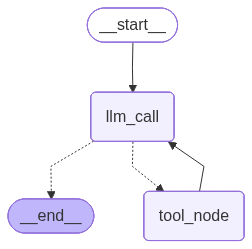

In [42]:
agent

In [50]:
msg = agent.get_state(config=config).values
msg


{'messages': [HumanMessage(content='What is 987654321 × 123456789? and then subtract it by 10034234234235300', additional_kwargs={}, response_metadata={}, id='c05134b4-095e-4948-802a-0d22e64537d7'),
  AIMessage(content='', additional_kwargs={'reasoning_content': "We need to compute product then subtract. Use multiply function for product, then subtract. Compute product = 987,654,321 * 123,456,789. Let's calculate via tool.", 'tool_calls': [{'id': 'fc_adcdf0c7-32d7-4c22-a664-2c88608a336b', 'function': {'arguments': '{"a":987654321,"b":123456789}', 'name': 'multiply'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 77, 'prompt_tokens': 450, 'total_tokens': 527, 'completion_time': 0.162693588, 'completion_tokens_details': {'reasoning_tokens': 40}, 'prompt_time': 1.087451603, 'prompt_tokens_details': {'cached_tokens': 256}, 'queue_time': 0.681284116, 'total_time': 1.250145191}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'serv

In [52]:
for m in msg['messages']:
    if isinstance(m, HumanMessage):
        print('Human')
        print(m.content)
    elif isinstance(m, AIMessage):
        print('\nAI')
        # print(m.additional_kwargs['reasoning_content'])
        print(m.content)
        print(m.tool_calls)
    else:
        print("\ntool")
        print(m)
    print('='*100)

Human
What is 987654321 × 123456789? and then subtract it by 10034234234235300

AI

[{'name': 'multiply', 'args': {'a': 987654321, 'b': 123456789}, 'id': 'fc_adcdf0c7-32d7-4c22-a664-2c88608a336b', 'type': 'tool_call'}]

tool
content='121932631112635269' id='7fa882cc-1776-4780-972f-783f2f5469ce' tool_call_id='fc_adcdf0c7-32d7-4c22-a664-2c88608a336b'

AI

[{'name': 'subtract', 'args': {'a': 121932631112635260, 'b': 10034234234235300}, 'id': 'fc_88462b10-26a1-49ca-9671-c2c21d986ed5', 'type': 'tool_call'}]

tool
content='111898396878399960' id='f4f90a63-ea4b-4bb9-bc37-1b31649399bb' tool_call_id='fc_88462b10-26a1-49ca-9671-c2c21d986ed5'

AI
\(987{,}654{,}321 \times 123{,}456{,}789 = 121{,}932{,}631{,}112{,}635{,}269\)

Subtracting \(10{,}034{,}234{,}234{,}235{,}300\):

\[
121{,}932{,}631{,}112{,}635{,}269 - 10{,}034{,}234{,}234{,}235{,}300 = 111{,}898{,}396{,}878{,}399{,}969.
\]

So the final result is **111,898,396,878,399,969**.
[]


In [45]:
for m in agent.get_state(config=config).values['messages']:
    print(m)

content='What is 987654321 × 123456789? and then subtract it by 10034234234235300' additional_kwargs={} response_metadata={} id='84dd2d17-da2a-44e4-8a54-7d0e19fb8542'
content='' additional_kwargs={'reasoning_content': "We need to compute product 987,654,321 * 123,456,789 then subtract 10,034,234,234,235,300. Use multiplication function. Let's compute product via multiply tool.", 'tool_calls': [{'id': 'fc_67f2e700-053c-41a3-b070-d21572833011', 'function': {'arguments': '{"a":987654321,"b":123456789}', 'name': 'multiply'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 82, 'prompt_tokens': 450, 'total_tokens': 532, 'completion_time': 0.17527128, 'completion_tokens_details': {'reasoning_tokens': 45}, 'prompt_time': 0.57257225, 'prompt_tokens_details': {'cached_tokens': 256}, 'queue_time': 0.633398368, 'total_time': 0.74784353}, 'model_name': 'openai/gpt-oss-120b', 'system_fingerprint': 'fp_e10890e4b9', 'service_tier': 'on_demand', 'finish_reason': 'tool_call

In [46]:
print(agent.get_state(config=config).values['messages'][-1].content)

The result is **111,898,396,878,399,960**.
